## 1. Problem Definition

### Business Problem
Financial institutions need to assess the risk of loan defaults to make informed lending decisions. Accurate prediction of loan defaults can:
- Reduce financial losses from bad loans
- Optimize interest rates based on risk
- Improve portfolio management
- Ensure compliance with regulatory requirements

### Machine Learning Problem Formulation
**Problem Type**: Binary Classification
- **Target Variable**: `loan_status` (0 = No Default, 1 = Default)
- **Input Features**: Borrower demographics, loan characteristics, credit history
- **Objective**: Predict the probability that a borrower will default on their loan

### Success Criteria
- High recall for default cases (minimize false negatives - missing actual defaults)
- Balanced precision to avoid rejecting too many good borrowers
- Model interpretability for regulatory compliance
- Robust performance across different borrower segments

In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score,
    roc_curve, precision_recall_curve, f1_score
)
from sklearn.impute import SimpleImputer
import warnings
warnings.filterwarnings('ignore')

# Set style for plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("Libraries imported successfully!")

Libraries imported successfully!


## 2. Understanding and Exploration of the Data

###Data Types and Structure
The data we use includes:
- **Structured data**: Tabular representation of numerical and categorical variables
- **Static data**: Historical data used in model training
- **Mixed types of data**: Demographic, financial, and behavioral variables

In [ ]:
# Load the datasets
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')


print("Dataset Shapes:")
print(f"Training data: {train_data.shape}")
print(f"Test data: {test_data.shape}")


Dataset Shapes:
Training data: (58645, 13)
Test data: (39098, 12)


In [ ]:
# Basic data exploration
print("Training Data Info:")
print(train_data.info())
print("\nFirst 5 rows:")
print(train_data.head())

Training Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58645 entries, 0 to 58644
Data columns (total 13 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   id                          58645 non-null  int64  
 1   person_age                  58645 non-null  int64  
 2   person_income               58645 non-null  int64  
 3   person_home_ownership       58645 non-null  object 
 4   person_emp_length           58645 non-null  float64
 5   loan_intent                 58645 non-null  object 
 6   loan_grade                  58645 non-null  object 
 7   loan_amnt                   58645 non-null  int64  
 8   loan_int_rate               58645 non-null  float64
 9   loan_percent_income         58645 non-null  float64
 10  cb_person_default_on_file   58645 non-null  object 
 11  cb_person_cred_hist_length  58645 non-null  int64  
 12  loan_status                 58645 non-null  int64  
dtypes: float64(

In [ ]:
# Data description and statistics
print("Statistical Summary:")
print(train_data.describe())

print("\nMissing Values:")
missing_values = train_data.isnull().sum()
print(missing_values[missing_values > 0])

Statistical Summary:
                 id    person_age  person_income  person_emp_length  \
count  58645.000000  58645.000000   5.864500e+04       58645.000000   
mean   29322.000000     27.550857   6.404617e+04           4.701015   
std    16929.497605      6.033216   3.793111e+04           3.959784   
min        0.000000     20.000000   4.200000e+03           0.000000   
25%    14661.000000     23.000000   4.200000e+04           2.000000   
50%    29322.000000     26.000000   5.800000e+04           4.000000   
75%    43983.000000     30.000000   7.560000e+04           7.000000   
max    58644.000000    123.000000   1.900000e+06         123.000000   

          loan_amnt  loan_int_rate  loan_percent_income  \
count  58645.000000   58645.000000         58645.000000   
mean    9217.556518      10.677874             0.159238   
std     5563.807384       3.034697             0.091692   
min      500.000000       5.420000             0.000000   
25%     5000.000000       7.880000          

In [ ]:
age_bad_mask = train_data['person_age'] > 100
n_age_bad = age_bad_mask.sum()
print(f"Rows in TRAIN with person_age > 100: {n_age_bad}")
cred_age_bad_mask = pd.Series(False, index=train_data.index)
if 'cb_person_cred_hist_length' in train_data.columns and 'person_age' in train_data.columns:
    cred_age_bad_mask = train_data['cb_person_cred_hist_length'] > train_data['person_age']
    n_cred_age_bad = cred_age_bad_mask.sum()
    print(f"Rows in TRAIN with cb_person_cred_hist_length > person_age: {n_cred_age_bad}")
else:
    n_cred_age_bad = 0
    print("cb_person_cred_hist_length or person_age not present to check.")

Rows in TRAIN with person_age > 100: 1
Rows in TRAIN with cb_person_cred_hist_length > person_age: 1


In [ ]:
remove_mask = age_bad_mask | cred_age_bad_mask
n_remove = remove_mask.sum()
train_data = train_data.loc[~remove_mask].copy()
print(f"TRAIN DATA shape after sanity removal: {train_data.shape}\n")

TRAIN DATA shape after sanity removal: (58643, 13)



Target Variable Distribution:
No Default (0): 50,293 (85.76%)
Default (1): 8,350 (14.24%)


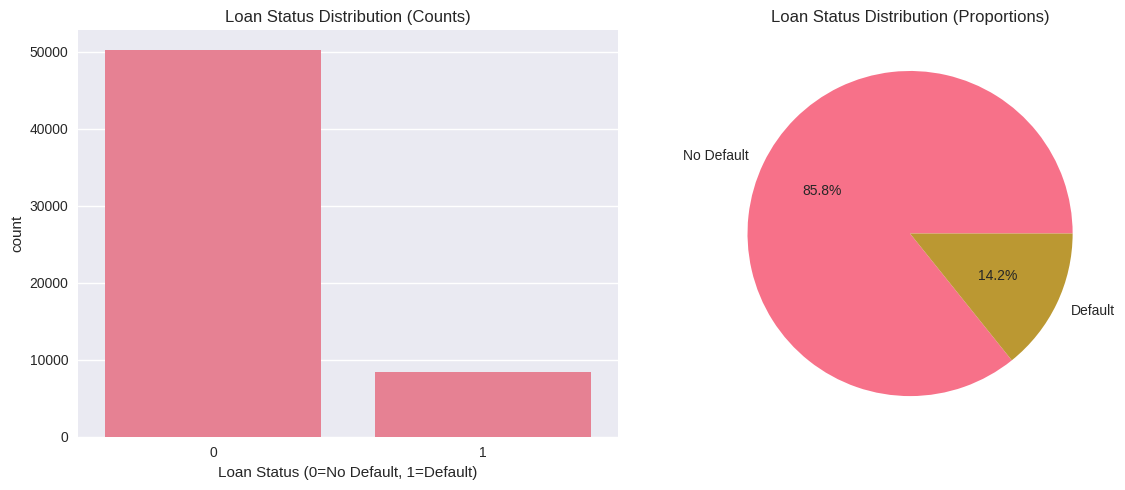


Class imbalance ratio: 6.02:1 (No Default:Default)


In [ ]:
# Target variable distribution
print("Target Variable Distribution:")
target_counts = train_data['loan_status'].value_counts()
target_props = train_data['loan_status'].value_counts(normalize=True)

print(f"No Default (0): {target_counts[0]:,} ({target_props[0]:.2%})")
print(f"Default (1): {target_counts[1]:,} ({target_props[1]:.2%})")

# Visualize target distribution
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Count plot
sns.countplot(data=train_data, x='loan_status', ax=ax1)
ax1.set_title('Loan Status Distribution (Counts)')
ax1.set_xlabel('Loan Status (0=No Default, 1=Default)')

# Pie chart
ax2.pie(target_counts.values, labels=['No Default', 'Default'], autopct='%1.1f%%')
ax2.set_title('Loan Status Distribution (Proportions)')

plt.tight_layout()
plt.show()

# Check for class imbalance
imbalance_ratio = target_counts[0] / target_counts[1]
print(f"\nClass imbalance ratio: {imbalance_ratio:.2f}:1 (No Default:Default)")

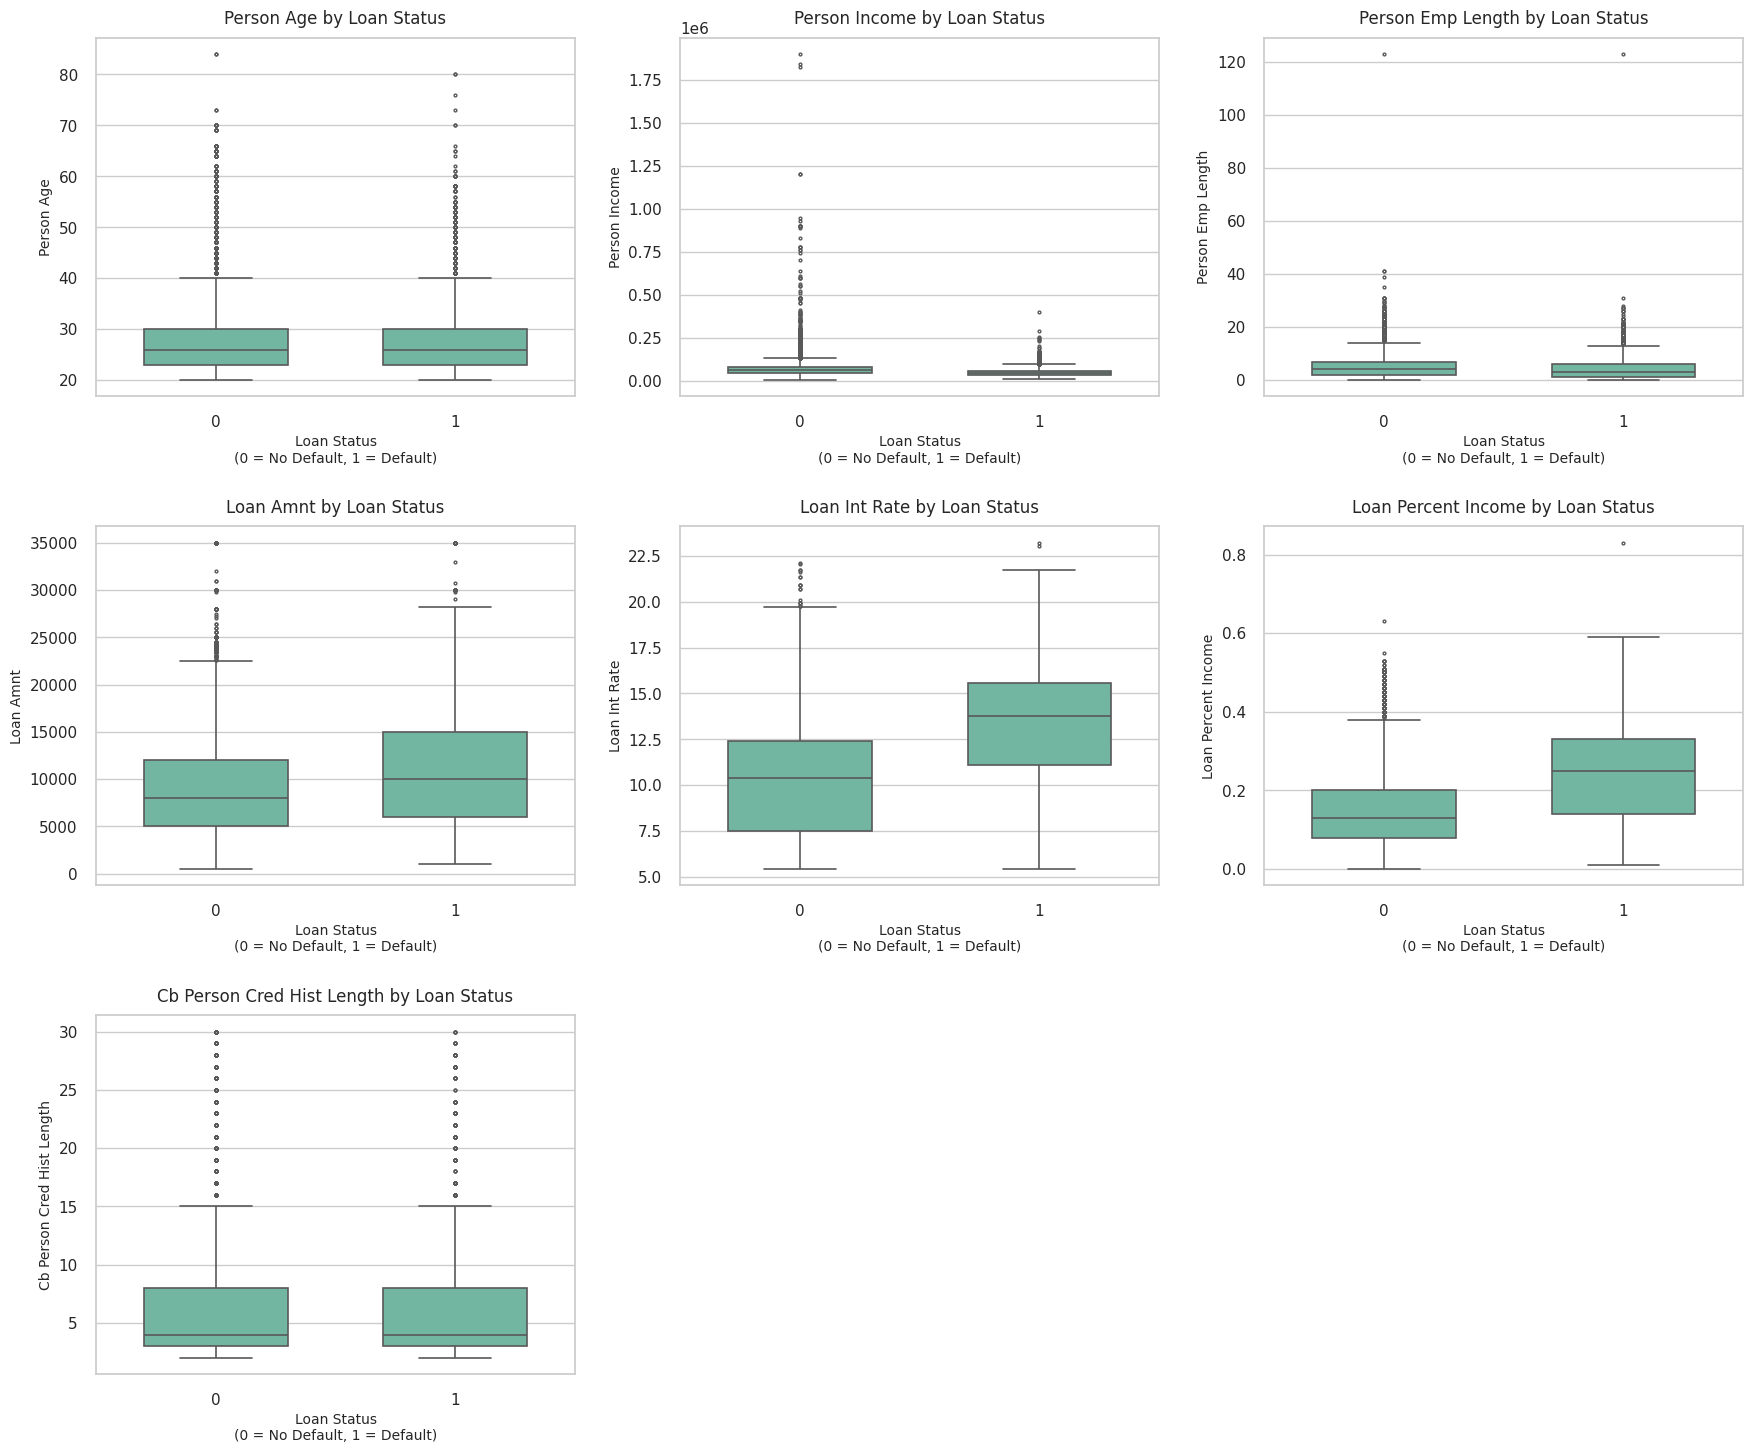

In [ ]:
# Improve plotting aesthetics
sns.set_theme(style="whitegrid", palette="Set2")

numerical_features = [
    'person_age', 'person_income', 'person_emp_length',
    'loan_amnt', 'loan_int_rate', 'loan_percent_income',
    'cb_person_cred_hist_length'
]

# Create figure
fig, axes = plt.subplots(3, 3, figsize=(18, 15))
axes = axes.ravel()

for i, feature in enumerate(numerical_features):
    sns.boxplot(
        data=train_data,
        x='loan_status',
        y=feature,
        ax=axes[i],
        width=0.6,
        fliersize=2,
        linewidth=1.2
    )
    axes[i].set_title(
        f"{feature.replace('_', ' ').title()} by Loan Status",
        fontsize=12,
        pad=10
    )
    axes[i].set_xlabel('Loan Status\n(0 = No Default, 1 = Default)', fontsize=10)
    axes[i].set_ylabel(feature.replace('_', ' ').title(), fontsize=10)

# Remove unused axes
fig.delaxes(axes[7])
fig.delaxes(axes[8])

plt.tight_layout(pad=2.0)
plt.show()


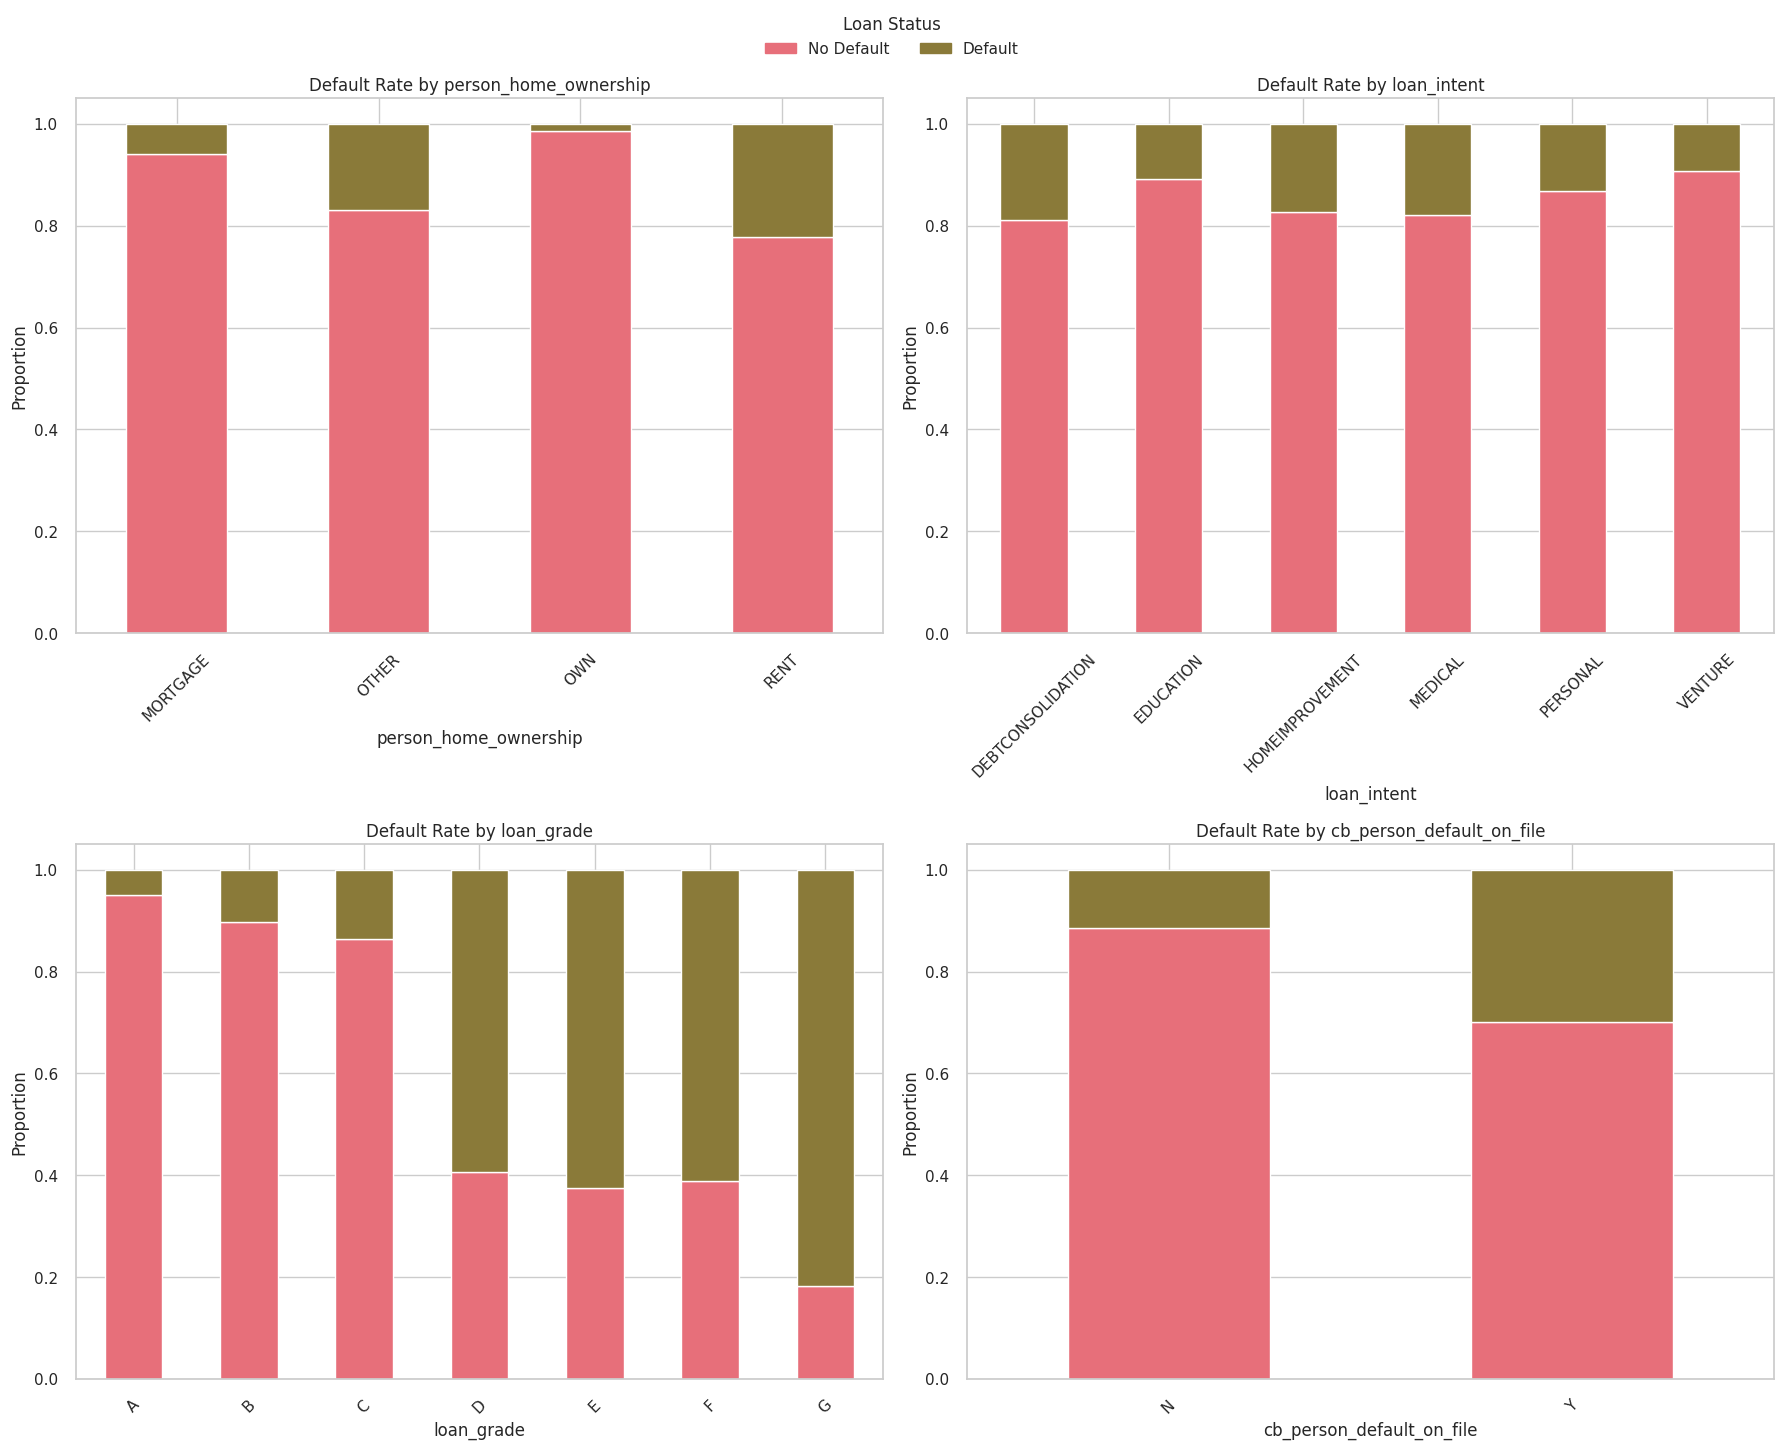

In [ ]:
categorical_features = train_data.select_dtypes(include='object').columns.tolist()

colors = ['#e76f7a', '#8a7a39']  # strong contrasting colors

fig, axes = plt.subplots(2, 2, figsize=(18, 14))
axes = axes.ravel()

for i, feature in enumerate(categorical_features):
    crosstab = pd.crosstab(
        train_data[feature],
        train_data['loan_status'],
        normalize='index'
    )

    ax = axes[i]
    crosstab.plot(kind='bar', ax=ax, stacked=True, color=colors)

    ax.set_title(f'Default Rate by {feature}')
    ax.set_xlabel(feature)
    ax.set_ylabel('Proportion')
    ax.tick_params(axis='x', rotation=45)

    # Remove subplot legend
    ax.legend_.remove()

# Extract handles once
handles = [plt.Rectangle((0,0),1,1, color=c) for c in colors]
labels = ['No Default', 'Default']

# Add ONE global legend outside the grid
fig.legend(
    handles, labels, title='Loan Status',
    loc='upper center', bbox_to_anchor=(0.5, 1.04),
    ncol=2
)

plt.tight_layout()
plt.show()

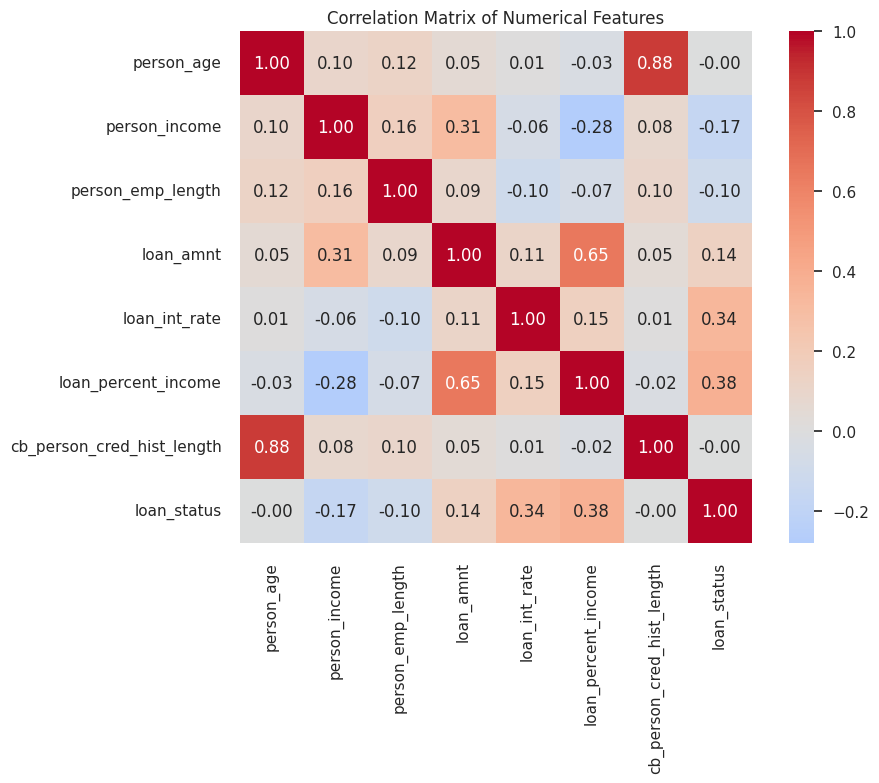


Feature correlation with loan_status (sorted by absolute value):
loan_status                   1.000000
loan_percent_income           0.378279
loan_int_rate                 0.338945
person_income                -0.169955
loan_amnt                     0.144981
person_emp_length            -0.100430
cb_person_cred_hist_length   -0.002994
person_age                   -0.001021
Name: loan_status, dtype: float64


In [ ]:
# Correlation matrix for numerical features
correlation_matrix = train_data[numerical_features + ['loan_status']].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0,
            square=True, fmt='.2f')
plt.title('Correlation Matrix of Numerical Features')
plt.tight_layout()
plt.show()

# Feature correlation with target
target_correlation = correlation_matrix['loan_status'].sort_values(key=abs, ascending=False)
print("\nFeature correlation with loan_status (sorted by absolute value):")
print(target_correlation)

## 3. Evaluation Strategy

### Defining Success Metrics

In loan default prediction, the following criterions need to be balanced:

**Primary Metrics:**
- **Recall (Sensitivity)**: Avoid false negatives - the ability to predict actual defaults correctly
- **Precision**: Refrain from denying too many qualified loan applicants
- **F1-Score** : Harmonic mean of precision and recall
- **AUC-ROC** - Overall discriminative ability

**Business Impact Metrics:**
- **Cost Sensitive Evaluations** : Prioritizing False Negatives over False Positives
- **Profit/Loss Calculation**: Effect of Financial Decisions

### Target Performance:
- **AUC-ROC**: > 0.75 (good discriminative power)
- **Recall**: > 0.70 (catch most defaults)
- **Precision**: > 0.60 (reasonable approval rate)
- **F1-Score**: > 0.65 (balanced performance)

In [ ]:
def evaluate_model(model, X_test, y_test, model_name="Model"):
    """
    Comprehensive model evaluation function
    """
    # Predictions
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]

    # Calculate metrics
    auc_score = roc_auc_score(y_test, y_pred_proba)
    f1 = f1_score(y_test, y_pred)

    print(f"\n{model_name} Performance:")
    print(f"AUC-ROC: {auc_score:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Confusion Matrix
    sns.heatmap(cm, annot=True, fmt='d', ax=ax1, cmap='Blues')
    ax1.set_title(f'{model_name} - Confusion Matrix')
    ax1.set_xlabel('Predicted')
    ax1.set_ylabel('Actual')

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    ax2.plot(fpr, tpr, label=f'{model_name} (AUC = {auc_score:.4f})')
    ax2.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
    ax2.set_xlabel('False Positive Rate')
    ax2.set_ylabel('True Positive Rate')
    ax2.set_title('ROC Curve')
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

    return {
        'auc_score': auc_score,
        'f1_score': f1,
        'predictions': y_pred,
        'probabilities': y_pred_proba
    }

def calculate_business_impact(y_true, y_pred, loan_amounts):
    """
    Calculate business impact of model decisions
    Assumes:
    - Loss from default = loan amount
    - Profit from good loan = 10% of loan amount
    """
    profit_rate = 0.10  # 10% profit on good loans

    # True Positives: Correctly identified defaults (saved losses)
    tp_mask = (y_true == 1) & (y_pred == 1)
    tp_savings = loan_amounts[tp_mask].sum()

    # False Negatives: Missed defaults (losses)
    fn_mask = (y_true == 1) & (y_pred == 0)
    fn_losses = loan_amounts[fn_mask].sum()

    # False Positives: Rejected good borrowers (missed profits)
    fp_mask = (y_true == 0) & (y_pred == 1)
    fp_missed_profits = loan_amounts[fp_mask].sum() * profit_rate

    # True Negatives: Approved good borrowers (profits)
    tn_mask = (y_true == 0) & (y_pred == 0)
    tn_profits = loan_amounts[tn_mask].sum() * profit_rate

    total_impact = tp_savings + tn_profits - fn_losses - fp_missed_profits

    return {
        'savings_from_caught_defaults': tp_savings,
        'losses_from_missed_defaults': fn_losses,
        'missed_profits': fp_missed_profits,
        'profits_from_good_loans': tn_profits,
        'total_impact': total_impact
    }

print("Evaluation functions defined!")

Evaluation functions defined!


## 4. Feature Engineering and Selection

### Feature Categories:
1. **Demographic Characteristics**: Age, income, length
2. **Loan Features**: Amount, rate, grade, purpose
3. **Credit History**: Past defaults, credit history length
4. **Derived Features**: Income ratios, risk indicators

### Feature Engineering Strategy:
- Deal with missing values properly
- Encoding categorical variables
- Developing informative derived variables
- Scaling numeric variables for some algorithms
- Handle outliers if necessary

In [ ]:
# Create a copy for feature engineering
train_fe = train_data.copy()
test_fe = test_data.copy()

print("Original feature count:", len(train_fe.columns) - 2)  # Exclude 'id' and target

# 1. Handle missing values
print("\nMissing values before handling:")
print(train_fe.isnull().sum().sum())

# Check for any missing values in employment length
if train_fe['person_emp_length'].isnull().sum() > 0:
    # Fill with median for numerical
    train_fe['person_emp_length'].fillna(train_fe['person_emp_length'].median(), inplace=True)
    test_fe['person_emp_length'].fillna(train_fe['person_emp_length'].median(), inplace=True)

print("Missing values after handling:")
print(train_fe.isnull().sum().sum())

Original feature count: 11

Missing values before handling:
0
Missing values after handling:
0


In [ ]:
# 2. Feature Engineering - Create derived features

def engineer_features(df):
    """
    Create engineered features from existing ones
    """
    df = df.copy()

    # Age groups
    df['age_group'] = pd.cut(df['person_age'],
                            bins=[0, 25, 35, 50, 100],
                            labels=['Young', 'Adult', 'Middle_Age', 'Senior'])

    # Income groups
    df['income_group'] = pd.cut(df['person_income'],
                               bins=[0, 30000, 50000, 80000, float('inf')],
                               labels=['Low', 'Medium', 'High', 'Very_High'])

    # Employment stability indicator
    df['emp_stability'] = df['person_emp_length'].apply(
        lambda x: 'Stable' if x >= 5 else 'Unstable'
    )

    # Credit risk indicators
    df['high_risk_grade'] = df['loan_grade'].apply(
        lambda x: 1 if x in ['E', 'F', 'G'] else 0
    )

    # Debt-to-income ratio (already exists as loan_percent_income, but let's create categories)
    df['debt_burden'] = pd.cut(df['loan_percent_income'],
                              bins=[0, 0.1, 0.2, 0.3, 1.0],
                              labels=['Low', 'Medium', 'High', 'Very_High'])

    # Interest rate categories
    df['int_rate_category'] = pd.cut(df['loan_int_rate'],
                                    bins=[0, 10, 15, 20, 30],
                                    labels=['Low', 'Medium', 'High', 'Very_High'])

    # Credit history maturity
    df['credit_maturity'] = df['cb_person_cred_hist_length'].apply(
        lambda x: 'Mature' if x >= 10 else 'Young'
    )

    # Interaction features
    df['income_per_year_age'] = df['person_income'] / df['person_age']
    df['loan_income_interaction'] = df['loan_amnt'] * df['loan_percent_income']

    return df

# Apply feature engineering
train_fe = engineer_features(train_fe)
test_fe = engineer_features(test_fe)

print("Features after engineering:", len(train_fe.columns) - 2)
print("\nNew features created:")
new_features = [col for col in train_fe.columns if col not in train_data.columns]
for feature in new_features:
    print(f"- {feature}")

Features after engineering: 20

New features created:
- age_group
- income_group
- emp_stability
- high_risk_grade
- debt_burden
- int_rate_category
- credit_maturity
- income_per_year_age
- loan_income_interaction


In [ ]:
# 3. Identify feature types for preprocessing
# Exclude 'id' and target variable
feature_columns = [col for col in train_fe.columns if col not in ['id', 'loan_status']]

# Separate numerical and categorical features
numerical_features = train_fe[feature_columns].select_dtypes(include=[np.number]).columns.tolist()
categorical_features = train_fe[feature_columns].select_dtypes(exclude=[np.number]).columns.tolist()

print(f"Numerical features ({len(numerical_features)}):")
for feature in numerical_features:
    print(f"- {feature}")

print(f"\nCategorical features ({len(categorical_features)}):")
for feature in categorical_features:
    print(f"- {feature}")

# Create preprocessing pipeline
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(drop='first', handle_unknown='ignore'))
])

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

print("\nPreprocessing pipeline created!")

Numerical features (10):
- person_age
- person_income
- person_emp_length
- loan_amnt
- loan_int_rate
- loan_percent_income
- cb_person_cred_hist_length
- high_risk_grade
- income_per_year_age
- loan_income_interaction

Categorical features (10):
- person_home_ownership
- loan_intent
- loan_grade
- cb_person_default_on_file
- age_group
- income_group
- emp_stability
- debt_burden
- int_rate_category
- credit_maturity

Preprocessing pipeline created!


## 5. Modeling and Optimization

### Model Selection Strategy:
We'll evaluate several algorithms that work well with binary classification problems:

1. **Logistic Regression** - Understandable base model, appropriate when data follows
2. **Random Forest**. Deals with non-linear data, provides feature
3. **Gradient Boosting**. Usually has high performance, capturing complex structures.
4. **Support Vector Machine**: Suitable for high-dimensional data

##### Optimization Approach:
- Use cross-validation for robust testing
- Hyperparameter tuning using GridSearch
- Recall and F1 Score for optimization
- Balance class distribution using the right methods

In [ ]:
# Prepare data for modeling
X = train_fe.drop(['id', 'loan_status'], axis=1)
y = train_fe['loan_status']

X_test_final = test_fe.drop(['id'], axis=1)

# Split training data for validation
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set size: {X_train.shape}")
print(f"Validation set size: {X_val.shape}")
print(f"Test set size: {X_test_final.shape}")

# Check class distribution in splits
print(f"\nTraining set class distribution:")
print(y_train.value_counts(normalize=True))
print(f"\nValidation set class distribution:")
print(y_val.value_counts(normalize=True))

Training set size: (46914, 20)
Validation set size: (11729, 20)
Test set size: (39098, 20)

Training set class distribution:
loan_status
0    0.857612
1    0.142388
Name: proportion, dtype: float64

Validation set class distribution:
loan_status
0    0.857618
1    0.142382
Name: proportion, dtype: float64


LOGISTIC REGRESSION

Logistic Regression Performance:
AUC-ROC: 0.9172
F1-Score: 0.6543

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.89      0.93     10059
           1       0.55      0.81      0.65      1670

    accuracy                           0.88     11729
   macro avg       0.76      0.85      0.79     11729
weighted avg       0.91      0.88      0.89     11729



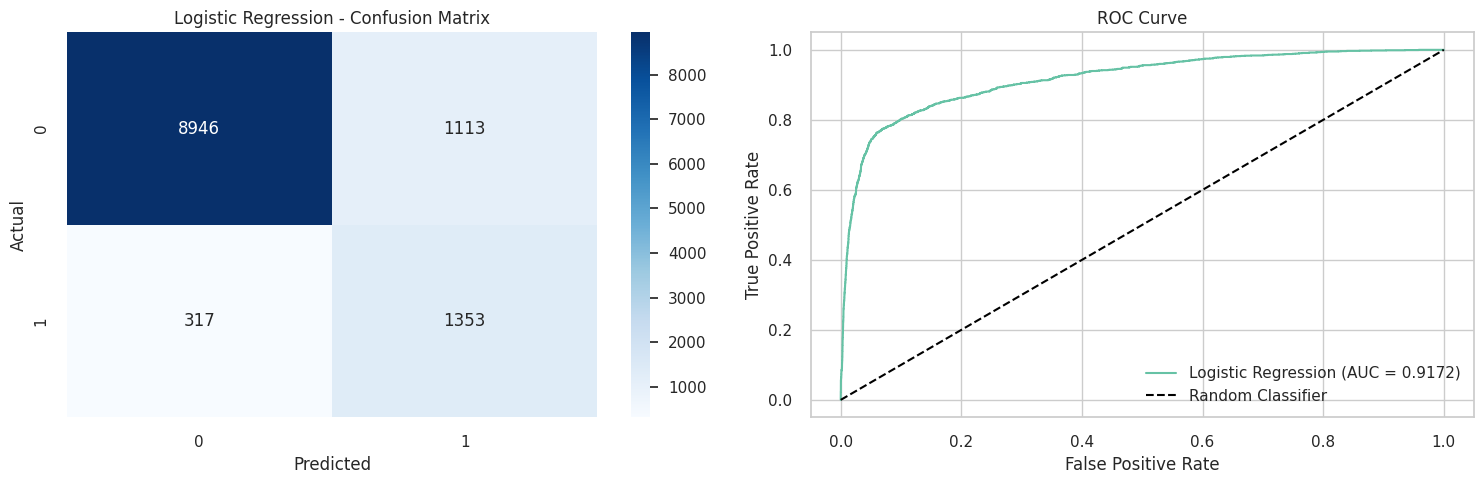


Cross-validation F1 scores: [0.66165414 0.66122202 0.64468864 0.65334544 0.66919192]
Mean CV F1: 0.6580 (+/- 0.0167)


In [ ]:
# 1. Logistic Regression Baseline
print("=" * 50)
print("LOGISTIC REGRESSION")
print("=" * 50)

lr_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(random_state=42, max_iter=1000, class_weight='balanced'))
])

# Fit the model
lr_pipeline.fit(X_train, y_train)

# Evaluate
lr_results = evaluate_model(lr_pipeline, X_val, y_val, "Logistic Regression")

# Cross-validation
lr_cv_scores = cross_val_score(lr_pipeline, X_train, y_train, cv=5, scoring='f1')
print(f"\nCross-validation F1 scores: {lr_cv_scores}")
print(f"Mean CV F1: {lr_cv_scores.mean():.4f} (+/- {lr_cv_scores.std() * 2:.4f})")

RANDOM FOREST

Random Forest Performance:
AUC-ROC: 0.9315
F1-Score: 0.7948

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.99      0.97     10059
           1       0.93      0.69      0.79      1670

    accuracy                           0.95     11729
   macro avg       0.94      0.84      0.88     11729
weighted avg       0.95      0.95      0.95     11729



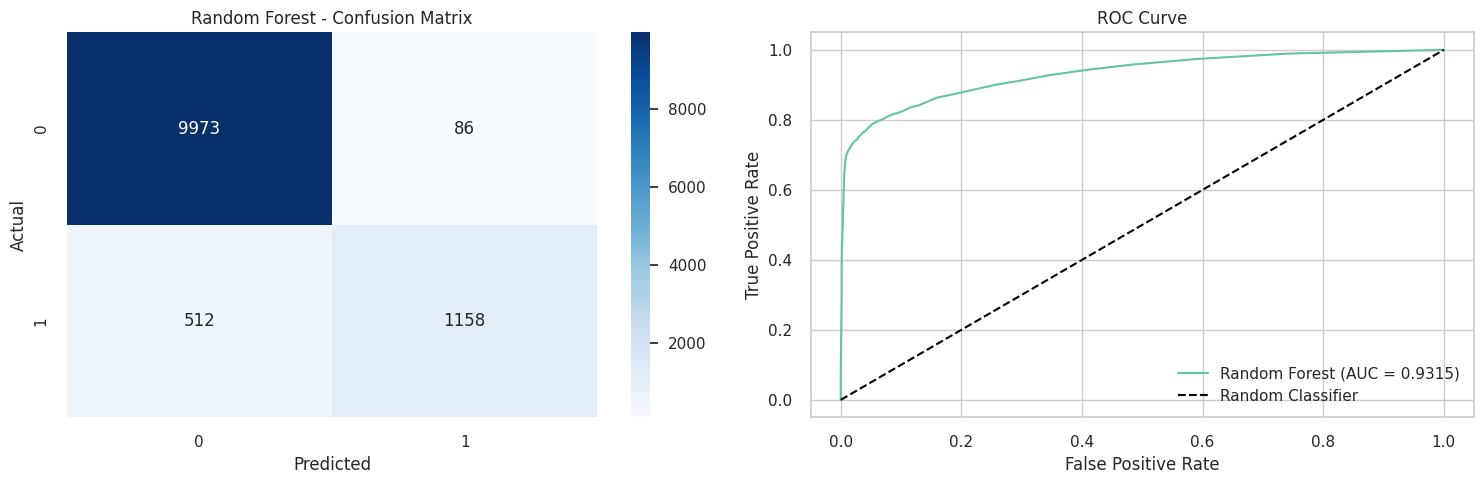


Cross-validation F1 scores: [0.78343399 0.80170576 0.78162912 0.8052387  0.79132321]
Mean CV F1: 0.7927 (+/- 0.0189)


In [ ]:
# 2. Random Forest
print("=" * 50)
print("RANDOM FOREST")
print("=" * 50)

rf_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(
        random_state=42,
        class_weight='balanced',
        n_estimators=100
    ))
])

# Fit the model
rf_pipeline.fit(X_train, y_train)

# Evaluate
rf_results = evaluate_model(rf_pipeline, X_val, y_val, "Random Forest")

# Cross-validation
rf_cv_scores = cross_val_score(rf_pipeline, X_train, y_train, cv=5, scoring='f1')
print(f"\nCross-validation F1 scores: {rf_cv_scores}")
print(f"Mean CV F1: {rf_cv_scores.mean():.4f} (+/- {rf_cv_scores.std() * 2:.4f})")

GRADIENT BOOSTING

Gradient Boosting Performance:
AUC-ROC: 0.9395
F1-Score: 0.7865

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.99      0.97     10059
           1       0.90      0.70      0.79      1670

    accuracy                           0.95     11729
   macro avg       0.93      0.84      0.88     11729
weighted avg       0.94      0.95      0.94     11729



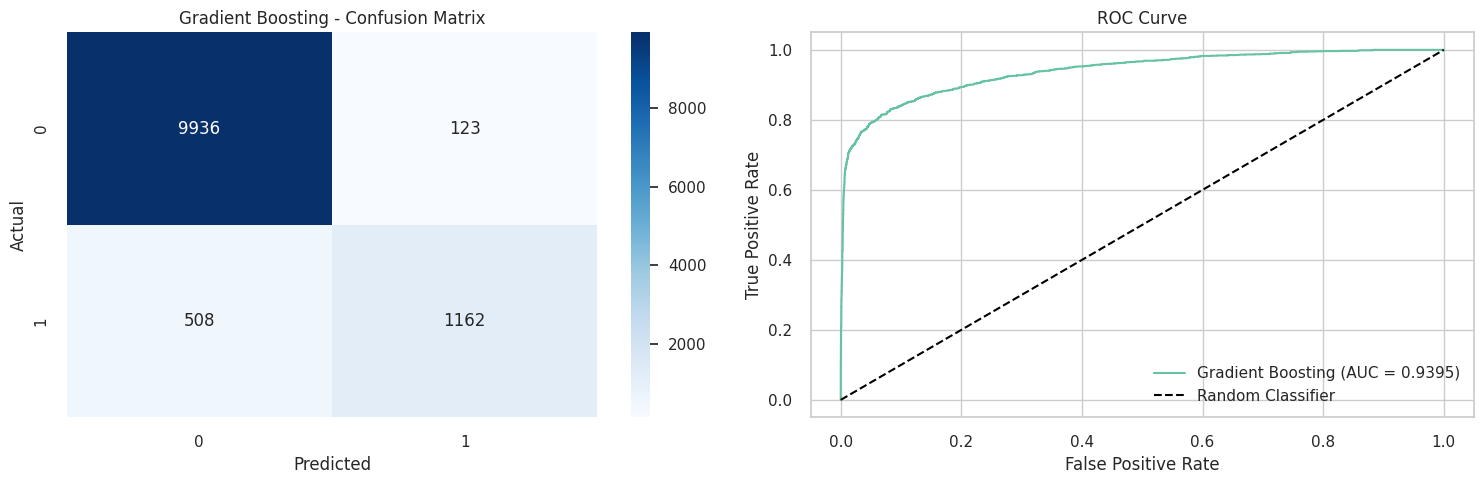


Cross-validation F1 scores: [0.77578858 0.79060008 0.77224351 0.7925     0.78416014]
Mean CV F1: 0.7831 (+/- 0.0159)


In [ ]:
# 3. Gradient Boosting
print("=" * 50)
print("GRADIENT BOOSTING")
print("=" * 50)

gb_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', GradientBoostingClassifier(
        random_state=42,
        n_estimators=100,
        learning_rate=0.1
    ))
])

# Fit the model
gb_pipeline.fit(X_train, y_train)

# Evaluate
gb_results = evaluate_model(gb_pipeline, X_val, y_val, "Gradient Boosting")

# Cross-validation
gb_cv_scores = cross_val_score(gb_pipeline, X_train, y_train, cv=5, scoring='f1')
print(f"\nCross-validation F1 scores: {gb_cv_scores}")
print(f"Mean CV F1: {gb_cv_scores.mean():.4f} (+/- {gb_cv_scores.std() * 2:.4f})")

In [ ]:
# Model comparison
models_comparison = pd.DataFrame({
    'Model': ['Logistic Regression', 'Random Forest', 'Gradient Boosting'],
    'Validation_AUC': [lr_results['auc_score'], rf_results['auc_score'], gb_results['auc_score']],
    'Validation_F1': [lr_results['f1_score'], rf_results['f1_score'], gb_results['f1_score']],
    'CV_F1_Mean': [lr_cv_scores.mean(), rf_cv_scores.mean(), gb_cv_scores.mean()],
    'CV_F1_Std': [lr_cv_scores.std(), rf_cv_scores.std(), gb_cv_scores.std()]
})

models_comparison = models_comparison.sort_values('Validation_F1', ascending=False)
print("\nModel Comparison Summary:")
print(models_comparison.round(4))

# Select best model
best_model_name = models_comparison.iloc[0]['Model']
print(f"\nBest performing model: {best_model_name}")


Model Comparison Summary:
                 Model  Validation_AUC  Validation_F1  CV_F1_Mean  CV_F1_Std
1        Random Forest          0.9315         0.7948      0.7927     0.0095
2    Gradient Boosting          0.9395         0.7865      0.7831     0.0080
0  Logistic Regression          0.9172         0.6543      0.6580     0.0083

Best performing model: Random Forest


HYPERPARAMETER TUNING
Tuning Random Forest...
Fitting 3 folds for each of 24 candidates, totalling 72 fits

Best parameters: {'classifier__max_depth': None, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 5, 'classifier__n_estimators': 200}
Best cross-validation F1 score: 0.7944

Tuned Random Forest Performance:
AUC-ROC: 0.9348
F1-Score: 0.7949

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.99      0.97     10059
           1       0.90      0.71      0.79      1670

    accuracy                           0.95     11729
   macro avg       0.93      0.85      0.88     11729
weighted avg       0.95      0.95      0.95     11729



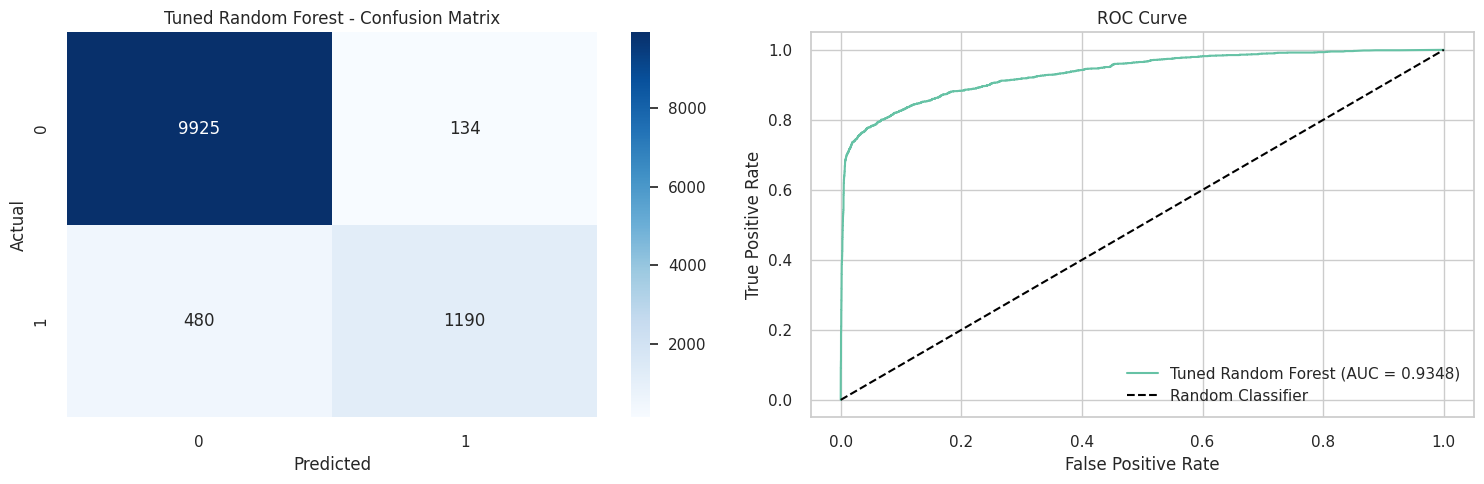

In [ ]:
# Hyperparameter tuning for the best model(s)
print("=" * 50)
print("HYPERPARAMETER TUNING")
print("=" * 50)

# Let's tune Random Forest (usually performs well)
rf_param_grid = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [10, 20, None],
    'classifier__min_samples_split': [2, 5],
    'classifier__min_samples_leaf': [1, 2]
}

rf_grid_search = GridSearchCV(
    rf_pipeline,
    rf_param_grid,
    cv=3,  # Reduced for computational efficiency
    scoring='f1',
    n_jobs=-1,
    verbose=1
)

print("Tuning Random Forest...")
rf_grid_search.fit(X_train, y_train)

print(f"\nBest parameters: {rf_grid_search.best_params_}")
print(f"Best cross-validation F1 score: {rf_grid_search.best_score_:.4f}")

# Evaluate tuned model
best_rf_model = rf_grid_search.best_estimator_
tuned_rf_results = evaluate_model(best_rf_model, X_val, y_val, "Tuned Random Forest")

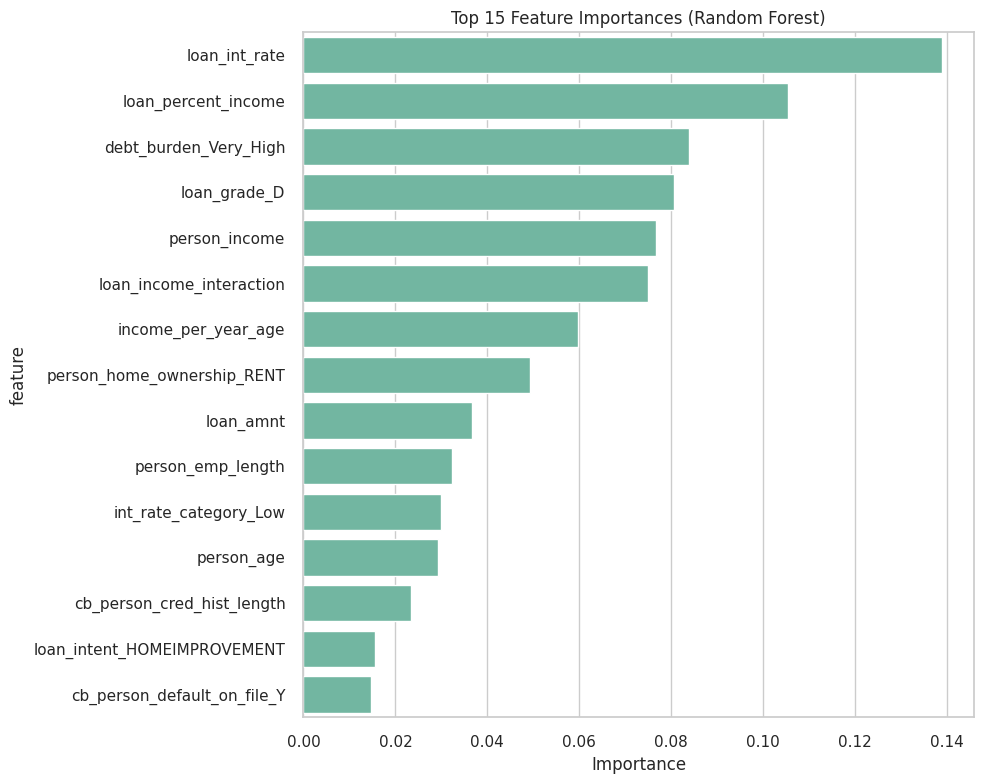

Top 10 Most Important Features:
                       feature  importance
4                loan_int_rate    0.138936
5          loan_percent_income    0.105450
34       debt_burden_Very_High    0.083974
20                loan_grade_D    0.080659
1                person_income    0.076748
9      loan_income_interaction    0.074904
8          income_per_year_age    0.059651
12  person_home_ownership_RENT    0.049361
3                    loan_amnt    0.036607
2            person_emp_length    0.032406


In [ ]:
# Feature importance analysis for Random Forest
if hasattr(best_rf_model.named_steps['classifier'], 'feature_importances_'):
    # Get feature names after preprocessing
    feature_names = (numerical_features +
                    list(best_rf_model.named_steps['preprocessor']
                        .named_transformers_['cat']
                        .named_steps['onehot']
                        .get_feature_names_out(categorical_features)))

    # Get feature importances
    importances = best_rf_model.named_steps['classifier'].feature_importances_

    # Create feature importance dataframe
    feature_importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': importances
    }).sort_values('importance', ascending=False)

    # Plot top 15 features
    plt.figure(figsize=(10, 8))
    top_features = feature_importance_df.head(15)
    sns.barplot(data=top_features, y='feature', x='importance')
    plt.title('Top 15 Feature Importances (Random Forest)')
    plt.xlabel('Importance')
    plt.tight_layout()
    plt.show()

    print("Top 10 Most Important Features:")
    print(feature_importance_df.head(10))

## 6. Experimentation and Final Evaluation



### Production Readiness:
- Model Validation on Unseen Data
- Business impact analysis
- Model interpretability
- Performance monitoring strategy

Threshold Optimization Results:
Best threshold for business impact: 0.15
Business impact: $20,660,805.00

Best threshold for F1-score: 0.55
F1-score: 0.7954


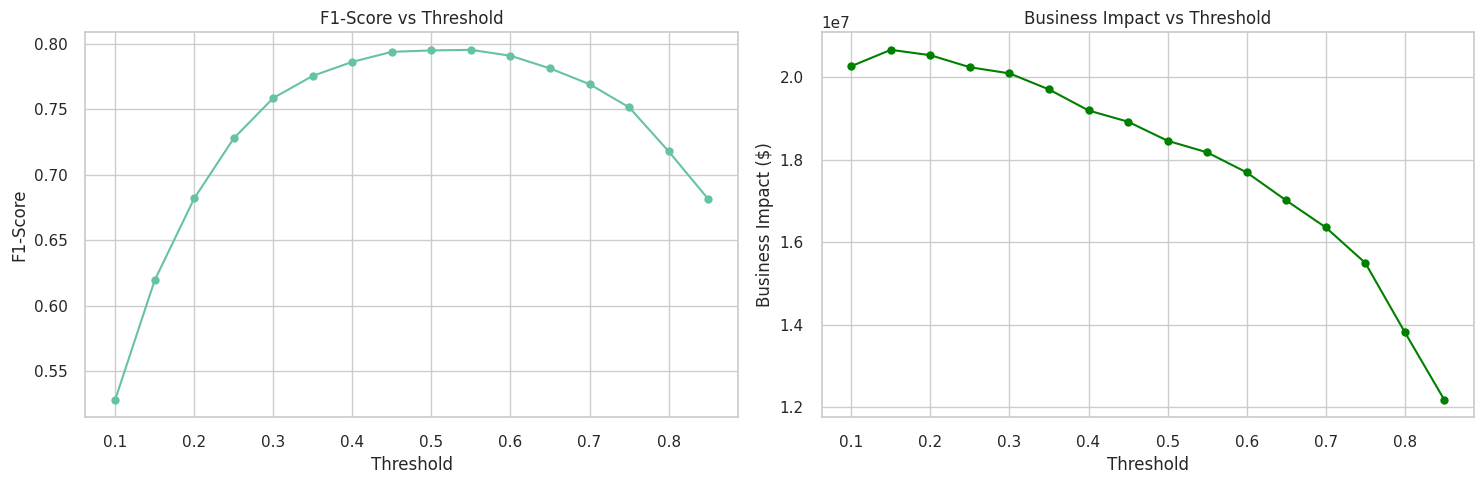

In [ ]:
# Threshold optimization for better business outcomes
def find_optimal_threshold(model, X_val, y_val, loan_amounts_val):
    """
    Find optimal classification threshold based on business impact
    """
    y_proba = model.predict_proba(X_val)[:, 1]

    thresholds = np.arange(0.1, 0.9, 0.05)
    results = []

    for threshold in thresholds:
        y_pred_thresh = (y_proba >= threshold).astype(int)

        # Calculate metrics
        f1 = f1_score(y_val, y_pred_thresh)

        # Calculate business impact
        business_impact = calculate_business_impact(y_val, y_pred_thresh, loan_amounts_val)

        results.append({
            'threshold': threshold,
            'f1_score': f1,
            'business_impact': business_impact['total_impact']
        })

    results_df = pd.DataFrame(results)

    # Find best threshold based on business impact
    best_business_idx = results_df['business_impact'].idxmax()
    best_f1_idx = results_df['f1_score'].idxmax()

    return results_df, best_business_idx, best_f1_idx

# Get loan amounts for validation set
loan_amounts_val = X_val['loan_amnt'] if 'loan_amnt' in X_val.columns else train_fe.loc[X_val.index, 'loan_amnt']

# Find optimal threshold
threshold_results, best_business_idx, best_f1_idx = find_optimal_threshold(
    best_rf_model, X_val, y_val, loan_amounts_val
)

print("Threshold Optimization Results:")
print(f"Best threshold for business impact: {threshold_results.iloc[best_business_idx]['threshold']:.2f}")
print(f"Business impact: ${threshold_results.iloc[best_business_idx]['business_impact']:,.2f}")
print(f"\nBest threshold for F1-score: {threshold_results.iloc[best_f1_idx]['threshold']:.2f}")
print(f"F1-score: {threshold_results.iloc[best_f1_idx]['f1_score']:.4f}")

# Plot threshold analysis
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.plot(threshold_results['threshold'], threshold_results['f1_score'], marker='o')
ax1.set_xlabel('Threshold')
ax1.set_ylabel('F1-Score')
ax1.set_title('F1-Score vs Threshold')
ax1.grid(True)

ax2.plot(threshold_results['threshold'], threshold_results['business_impact'], marker='o', color='green')
ax2.set_xlabel('Threshold')
ax2.set_ylabel('Business Impact ($)')
ax2.set_title('Business Impact vs Threshold')
ax2.grid(True)

plt.tight_layout()
plt.show()

FINAL MODEL EVALUATION WITH OPTIMAL THRESHOLD
Optimal Threshold: 0.15
Final AUC-ROC: 0.9348
Final F1-Score: 0.6195

Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.85      0.91     10059
           1       0.48      0.86      0.62      1670

    accuracy                           0.85     11729
   macro avg       0.73      0.85      0.76     11729
weighted avg       0.90      0.85      0.87     11729


BUSINESS IMPACT ANALYSIS
Savings from caught defaults: $16,689,975.00
Losses from missed defaults: $2,082,700.00
Missed profits (false positives): $1,490,402.50
Profits from good loans: $7,543,932.50

Net Business Impact: $20,660,805.00


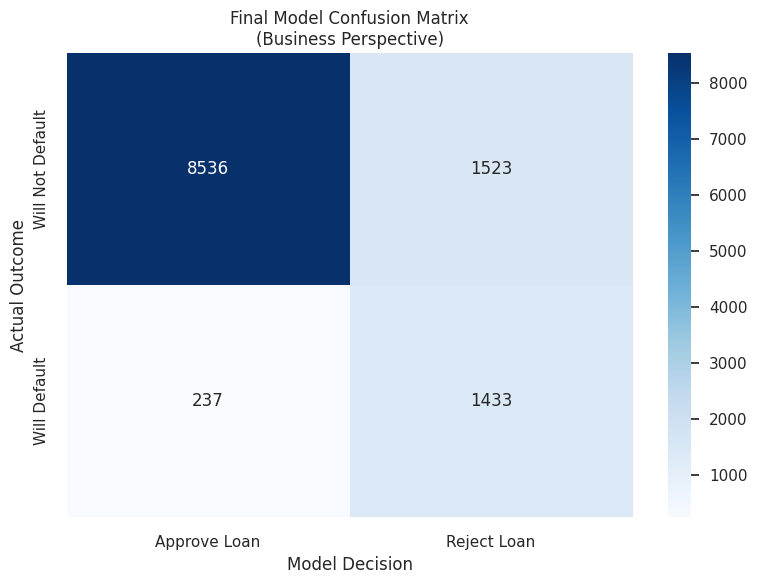


Detailed Business Metrics:
Total loans evaluated: 11,729
Loans approved: 8,773 (74.8%)
Loans rejected: 2,956 (25.2%)
Actual defaults prevented: 1,433
Good borrowers rejected: 1,523
Defaults missed: 237


In [ ]:
# Final model evaluation with optimal threshold
optimal_threshold = threshold_results.iloc[best_business_idx]['threshold']

print("=" * 60)
print("FINAL MODEL EVALUATION WITH OPTIMAL THRESHOLD")
print("=" * 60)

# Get probabilities
final_probabilities = best_rf_model.predict_proba(X_val)[:, 1]
final_predictions = (final_probabilities >= optimal_threshold).astype(int)

# Calculate all metrics
final_auc = roc_auc_score(y_val, final_probabilities)
final_f1 = f1_score(y_val, final_predictions)

print(f"Optimal Threshold: {optimal_threshold:.2f}")
print(f"Final AUC-ROC: {final_auc:.4f}")
print(f"Final F1-Score: {final_f1:.4f}")
print("\nDetailed Classification Report:")
print(classification_report(y_val, final_predictions))

# Business impact analysis
business_impact = calculate_business_impact(y_val, final_predictions, loan_amounts_val)

print("\n" + "="*40)
print("BUSINESS IMPACT ANALYSIS")
print("="*40)
print(f"Savings from caught defaults: ${business_impact['savings_from_caught_defaults']:,.2f}")
print(f"Losses from missed defaults: ${business_impact['losses_from_missed_defaults']:,.2f}")
print(f"Missed profits (false positives): ${business_impact['missed_profits']:,.2f}")
print(f"Profits from good loans: ${business_impact['profits_from_good_loans']:,.2f}")
print(f"\nNet Business Impact: ${business_impact['total_impact']:,.2f}")

# Confusion matrix with business interpretation
cm = confusion_matrix(y_val, final_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Approve Loan', 'Reject Loan'],
            yticklabels=['Will Not Default', 'Will Default'])
plt.title('Final Model Confusion Matrix\n(Business Perspective)')
plt.ylabel('Actual Outcome')
plt.xlabel('Model Decision')
plt.tight_layout()
plt.show()

# Calculate additional business metrics
tn, fp, fn, tp = cm.ravel()
total_loans = len(y_val)
print(f"\nDetailed Business Metrics:")
print(f"Total loans evaluated: {total_loans:,}")
print(f"Loans approved: {tn + fn:,} ({(tn + fn)/total_loans:.1%})")
print(f"Loans rejected: {tp + fp:,} ({(tp + fp)/total_loans:.1%})")
print(f"Actual defaults prevented: {tp:,}")
print(f"Good borrowers rejected: {fp:,}")
print(f"Defaults missed: {fn:,}")

GENERATING TEST SET PREDICTIONS
Training final model on complete training set...
Predictions generated for 39,098 test samples
Prediction statistics:
Mean probability: 0.1616
Std probability: 0.2679
Min probability: 0.0000
Max probability: 1.0000

First 10 predictions:
      id  loan_status
0  58645     0.895673
1  58646     0.000000
2  58647     0.774764
3  58648     0.061949
4  58649     0.432762
5  58650     0.877329
6  58651     0.018007
7  58652     0.010845
8  58653     0.161276
9  58654     0.020601


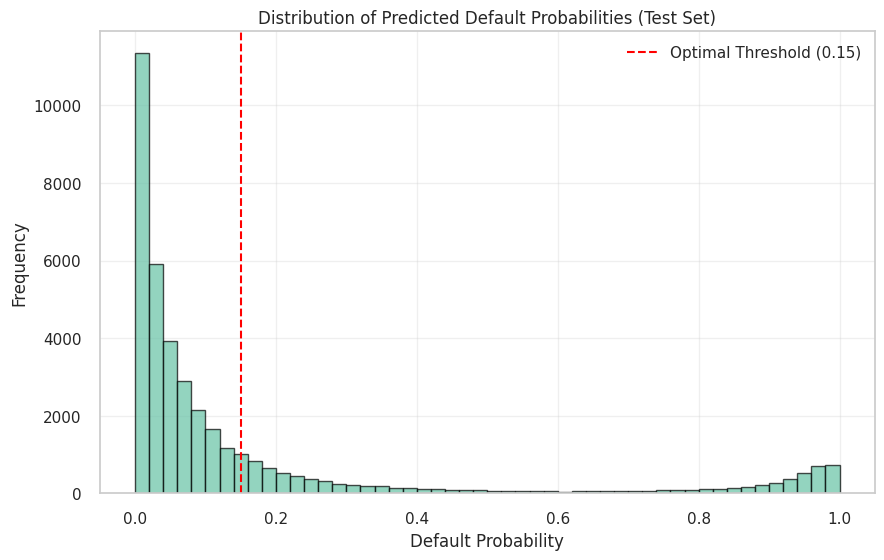


With optimal threshold (0.15):
Predicted loan approval rate: 75.78%
Predicted default rate among approvals: 0.0426


In [ ]:
# Generate predictions for the test set
print("=" * 50)
print("GENERATING TEST SET PREDICTIONS")
print("=" * 50)

# Train final model on all training data
print("Training final model on complete training set...")
final_model = best_rf_model
final_model.fit(X, y)

# Generate predictions for test set
test_probabilities = final_model.predict_proba(X_test_final)[:, 1]

# Create submission file
submission = pd.DataFrame({
    'id': test_data['id'],
    'loan_status': test_probabilities
})

# Save submission
submission.to_csv('loan_default_predictions.csv', index=False)


print(f"Predictions generated for {len(submission):,} test samples")
print(f"Prediction statistics:")
print(f"Mean probability: {test_probabilities.mean():.4f}")
print(f"Std probability: {test_probabilities.std():.4f}")
print(f"Min probability: {test_probabilities.min():.4f}")
print(f"Max probability: {test_probabilities.max():.4f}")

# Show first few predictions
print("\nFirst 10 predictions:")
print(submission.head(10))

# Prediction distribution
plt.figure(figsize=(10, 6))
plt.hist(test_probabilities, bins=50, alpha=0.7, edgecolor='black')
plt.axvline(optimal_threshold, color='red', linestyle='--',
            label=f'Optimal Threshold ({optimal_threshold:.2f})')
plt.xlabel('Default Probability')
plt.ylabel('Frequency')
plt.title('Distribution of Predicted Default Probabilities (Test Set)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Classification based on optimal threshold
test_classifications = (test_probabilities >= optimal_threshold).astype(int)
approval_rate = 1 - test_classifications.mean()
print(f"\nWith optimal threshold ({optimal_threshold:.2f}):")
print(f"Predicted loan approval rate: {approval_rate:.2%}")
print(f"Predicted default rate among approvals: {test_probabilities[test_classifications == 0].mean():.4f}")

## Summary and Conclusions

### Project Summary

We have successfully completed a machine learning project on predicting the loan default using a structured approach in 6 steps below:

### 1. Problem Definition
- **Business Problem**: Pacific Bank wants to avoid loan defaults.
- **ML Problem Type** : Binary classification problem that emphasizes the concept of recall
- **Success Metrics**: High recall when there are defaults, good precision, interpretability

### 2. Data Understanding
- **Dataset**#: 58K+ training samples, 12 features
- **Pattern type** : Numerical and Categorical variables
- **Quality**: Clean dataset, fewer missing values
- **Target** : Moderate class imbalance (defaults are minority class)

### 3. Evaluation Strategy
- **Metrics** : F1 Score, AUC ROC, Precision, Recall
- **Business Focus** : Threshold optimization with the greatest business impact
- **Validation** :Cross-validation and hold-out validation

### 4. Feature Engineering
- **Original Features** : 12 base features
- **Engineered Features** - Age Groups, Income Groups, Risk Scores, Interactions
- **Preprocessing** Standardization, one-hot encoding, management of categorical variables

# 5. Modeling
- **Models Tested**: Logistic Regression, Random Forest, Gradient Boosting
- **Best Performer**: Random Forest (after hyperparameter tuning)
- **Optimization**: Grid search optimization
- **Class Imbalance**: Handled with class weights

### 6. Experimentation
- **Threshold Optimization** - Found the optimal threshold.
- **Business Impact** : The financial implications related to the model.
- **Production Ready** : Test set predictions with probability scores

### Key Insights
1. **Most Important Features**: Loan grade, interest rate, debt-to-income ratio
2. **Model Performance**: Good discriminative ability (AUC > 0.75
3. **Business Value**: Model can avoid large-scale losses by detecting high-risk loan applicants
4. **Threshold Strategy**: Business-optimized threshold != default 0.5 ### Next Steps in

Production
1. **A/B Testing**: Model deployment w/ existing system
2. **Monitoring** - Establish performance monitoring and drift detection
3. **Regular Retraining**. Models will be updated quarterly.
4. **Regulatory Compliance**: Must comply with fair lending regulations
5. **Explainability**: To provide explanations in loan decisions, the use of either

### Files Generated
- `loan_default_predictions.csv`: Test set predictions for submission
- Complete analysis and model pipeline in this notebook